<a href="https://colab.research.google.com/github/Rogerio-mack/Temporal/blob/main/cap6_aprendizado_de_maquina_V2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# Bibliotecas básica a serem importadas

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import random
import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
path = 'https://github.com/Rogerio-mack/Temporal/raw/main/Data/'


In [3]:
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

import matplotlib.dates as mdates
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima.model import ARIMAResults
import statsmodels.api as qqplot
import scipy.stats as stats

In [4]:
#@markdown `tspplot()`
def tspplot(ts=None,label=None,title=None,ax=None,linestyle='solid',alpha=1,lw=1,nr_xticks=None,nr_yticks=None,xlabel=None):
  
  import matplotlib.ticker as ticker

  if ax is None:
    fig, ax = plt.subplots()
  
  if label is not None:
    ax.plot(ts, label=label, linestyle=linestyle, lw=lw)
  else:
    ax.plot(ts, linestyle=linestyle,lw=lw,alpha=alpha)

  if title is not None:
    ax.set_title(title)

  if xlabel is not None:
    ax.set_xlabel(xlabel)

  if nr_xticks is not None:
    ax.xaxis.set_major_locator(ticker.MaxNLocator(nr_xticks))

  if nr_yticks is not None:
    ax.yaxis.set_major_locator(ticker.MaxNLocator(nr_yticks))  
  
  if label is not None:
    plt.legend()

  plt.tight_layout()

  return


In [5]:
#@markdown `tspdisplay()`
class tspdisplay(object):
    # Adaptado de https://jakevdp.github.io/PythonDataScienceHandbook/index.html
    """Display HTML representation of multiple objects"""
    template = """<div style="float: left; padding: 10px;">
    <hr>
    <h3 style='font-family:"Courier New", Courier, monospace'>{0}</h3><hr>{1}
    </div>"""
    def __init__(self, *args):
        self.args = args
        
    def _repr_html_(self):
        return '\n'.join(self.template.format(a, eval(a + '.head()')._repr_html_())
                         for a in self.args)
    
    def __repr__(self):
        return '\n\n'.join(a + '\n' + repr(eval(a + '.head()'))
                           for a in self.args)

# **4. Modelos de Predição ARMA e ARIMA**
---

Neste capítulo, você irá aprender:

1. O uso dos modelos ARMA e ARIMA para fazer previsões.
2. Analisar os resíduos do ajuste dos modelos ARMA e ARIMA.
3. O uso da *library statsmodels* para ajustar modelos ARIMA




Neste capítulo, você vai estudar os modelos Autorregressivos Integrados de médias móveis (ARIMA) amplamente utilizados na literatura para modelar séries temporais estacionárias e/ou não estacionárias (com tendência estocástica) visando fazer previsões e/ou descrever o comportamento dos dados. A ideia principal da estrutura destes modelos consiste em modelar a dependencia serial dos dados, uma vez que, na prática, na maioria das séries, observa-se que os valores recentes estão correlacionados com seus valores passados e que a força dessa dependência diminui (ou aumenta) quando considerados valores mais distantes no tempo. Imagine que desejamos prever a taxa de câmbio do dólar, assim, é razoável pensar que o valor de amanhã está correlacionado com os valores observados recentemente e que essa correlação diminui conforme nos afastamos no tempo.

O modelo ARIMA pode ser analisando decompondo-o em três partes: AR(parte Autorregressiva), I (parte integrada) e MA (Médias móveis). Seja $Y_t$ o valor observado de uma série no instante $t$. 

*   A parte autoregressiva permite modelar, por meio de valores defasados da série ($Y_{t-i}$), a dependencia serial do valor atual ($Y_t$) com $p$ valores passados da série $(Y_{t-1},...Y_{t-p})$. Assim, as previsões serão baseadas em valores passados da série.

*   Na prática, a maioria das séries apresentam padrões de crescimento ou decrescimento em alguns períodos de tempo. Estas séries podem tornar-se estacionárias por meio de um número finito (geralmente um ou dois) de diferenças. A parte integrada, refere-se ao número de diferenças necessárias para tornar a série em estacionária. 

*   As médias móveis modelam a série temporal por meio de uma combinação linear de ruídos branco ( valores independentes com média zero e  variância constante). Sua interpretação é menos intuitiva e geralmente esses termos são adicionados no modelo para diminuir o número de termos defasados na parte AR.


Em geral, os modelos ARIMA permitem modelar processos chamados de não estacionários homogêneos, denotado por ARIMA(p,d,q), em que $d$ indica o número de diferenças necessárias para que a série $Y_t$ se torne estacionária, $p$ é o número total de termos defasados da série que serão considerados na parte AR e $q$ o número total de erros aleatórios defasados que serão considerados na parte MA. Assim, o modelo ARIMA pode ser representado como:

$$W_t=\underbrace{\Delta^d Y_t}_\text{série após d diferenças}$$


$${W_t} =\phi_0+ \underbrace{\phi_1 W_{t-1}+ \phi_2 W_{t-2}+...+\phi_p  W_{t-p}}_\text { p - termos autorregressivos} +\underbrace{\theta_1e_{t-1}+ \theta_2 e_{t-2}+...+ \theta_q e_{t-q}}_\text{ q- termos de Médias móveis} + e_t , $$

em que $\phi_1,...,\phi_p, \theta_1,...,\theta_q$ são valores a serem estimados e, geralmente, o ruído branco, $e_t$, segue uma distribuição Normal.  Antes de estudar os modelos ARIMA, devemos primeiro discutir o conceito de estacionariedade e a técnica de diferenciação de séries temporais.

## Conceitos importantes 


A seguir, vamos discutir, no contexto dos modelos ARIMA, os conceitos de estacionariedade, função de autocorrelação e autocorrelação parcial e o método de diferenciação. Nesta seção analisaremos três séries temporais: 

- Exportação trimestral de bens e serviços no Brasil, valores a preços correntes (Milhões de Reais) no período de janeiro de 1996 a dezembro de 2021.
- Índice mensal do volume de vendas de materiais de construção no Brasil no período de janeiro de 2005 a dezembro de 2015.
- Variação diária da cotação do dólar em relação ao real de julho de 2018 a dezembro de 2019.

In [6]:
# Lendo a base de dados
df1=pd.read_csv(path+'exportacoes.csv', delimiter=';', decimal=",")
df2=pd.read_csv(path+'dolar.csv', delimiter=';', decimal=",")
df3=pd.read_csv(path+'vendas.csv', delimiter=';', decimal=",")

In [7]:
# Arrumando o index
df1.index = pd.date_range(start='3/1/1996', end='12/31/2021', freq='3M')
df2.index = pd.date_range(start='7/2/2018', end='12/31/2019', freq='B')
df3.index = pd.date_range(start='1/1/2005', end='12/31/2015', freq='M')

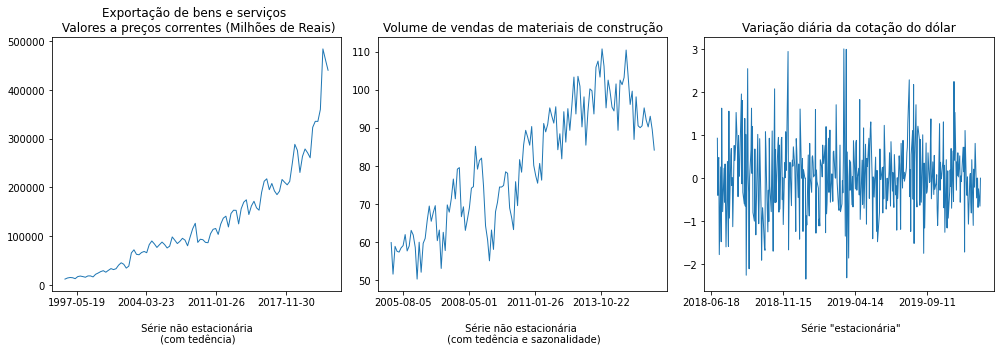

In [8]:
#@markdown  
fig, ax = plt.subplots(1,3,figsize=(14,5))

show_files = [df1.Exportações, df3["volume_vendas"], df2["Var"]]
titles=["Exportação de bens e serviços \n Valores a preços correntes (Milhões de Reais)",
        "Volume de vendas de materiais de construção",
        "Variação diária da cotação do dólar"]
xlabel=["\n Série não estacionária \n (com tedência)",
        "\n Série não estacionária  \n (com tedência e sazonalidade)",
        '\n Série "estacionária"']
for i, axis in enumerate(fig.axes):
  tspplot(show_files[i],xlabel=xlabel[i],title=titles[i],ax=axis,nr_xticks=5)

### Estacionariedade

Como discutimos no Capítulo 1, em **processos estacionários**, intuitivamente, as observações se desenvolvem aleatoriamente em torno de um certo nível com variabilidade constante. Repare que a única série, aparentemente, estacionária é a Variação diária do dolar cujos valores estão na faixa de -3 a 3 e se desenvolvem em torno de zero com variança constante. As outras duas séries apresentam tendência crescente e o volume de vendas de materias de construção um comportamento sazonal que aparentemente se repete a cada ano. 

No decorrer deste capítulo vamos estudar o teste de Dickey-Fuller que permite verificar estatísticamente se a série de interesse é estacionária ou não testando a presença de tendência estócastica.

### Diferenciação

Muitas séries analisadas na prática são não estacionárias, mas ao tomarmos algumas diferenças a série se torna estacionária.  Tomando-se uma diferença elimina-se uma tendência linear. Seja $Y_t$ o valor da série no instante $t$. A primeira diferença é dada por:

$$ \Delta Y_t = Y_t -Y_{t-1} $$

Em geral, tomar uma ou duas diferenças é suficiente para eliminar tendências da série e torná-la estacionária.

**Exemplo**. A série trimestral Exportação de bens e serviços no Brasil apresenta uma tendência crescente, vamos aplicar uma diferença para visualizar o efeito.

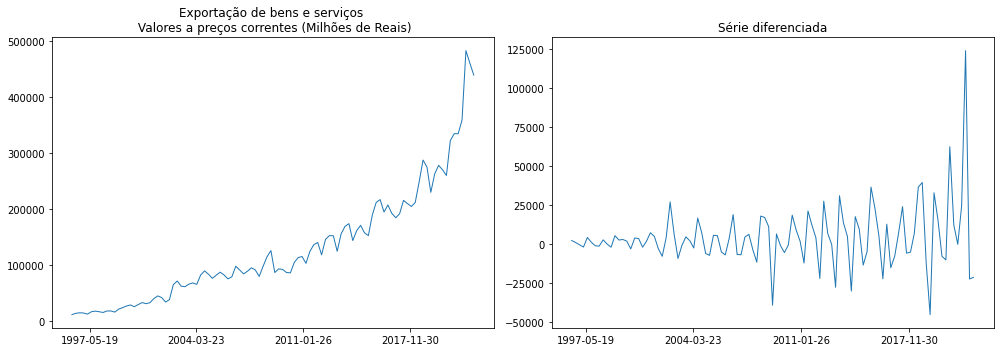

In [9]:
#@markdown  
fig, ax = plt.subplots(1,2,figsize=(14,5))

show_files = [df1.Exportações, df1.Exportações.diff()]
titles=["Exportação de bens e serviços \n Valores a preços correntes (Milhões de Reais)",
        "Série diferenciada"]

for i, axis in enumerate(fig.axes):
  tspplot(show_files[i],title=titles[i],ax=axis,nr_xticks=5)

Observa-se que a série diferenciada varia em torno de zero. Você pode notar que há um aumento da variabilidade ao longo do tempo, um possível procedimento recomendado nestes casos é aplicar a função logaritmo, antes de diferenciar a série, e modelar os valores transformados.

Quando a série é sazonal  é apropriado tomar as diferenças para o período de sazonalidade. Considere o caso de uma série mensal cujos valores apresentam um comportamento períodico que se repete a cada ano. Assim, recomenda-se tomar uma diferença sazonal do tipo:
$$ \Delta Y_t = Y_t -Y_{t-12} $$
Iremos discutir mais detalhadamente esse tipo de diferença sazonal no seguinte Capítulo no uso dos modelos SARIMA.


### Função de autocorrelação

No processo de identificação de modelos ARIMA, a análise da estrutura de dependência serial dos dados é fundamental. Em algumas séries, observa-se que o valor atual está correlacionado com seus valores passados e a força dessa dependência diminui quando considerados valores mais distantes no tempo. Essas defasagens são também chamadas usualmente de "lags".

A função de autocorrelacão (ACF) permite visualizar as correlações entre observações distantes $k$ períodos de tempo. Assim, para um "lag=1" representa-se como valores sucessivos da série estão correlacionados. Você pode reparar que para "lag=0" o valor da correlação sempre será um, por que?

Na função de autocorrelação amostral, função usada para ajudar a identificar um modelo ARIMA,  intervalos de confiança de 95% são traçados para verificar se as autocorrelações são significativamente diferentes de zero.


**Exemplo**. 
A seguir apresenta-se o ACF de uma série (simulada) cujos valores sucessivos estão correlacionados. A série foi gerada de tal forma que a correlação entre o valor no instante $t$ e $t-1$ seja de $0,7$. Note que a correlação da série no instate $t$ e $t-k$ diminuiu quando $k$ aumenta, i.e, quando analisamos a correlação da série no instante $t$ com valores mais distantes no tempo. Faz sentido, não?

In [10]:
# Simulando uma série com valores sucessivos correlacionados
ar1 = np.array([1,-0.7])
ma1 = np.array([1])

AR_object1 = ArmaProcess(ar1,ma1)
simulated_data = AR_object1.generate_sample(nsample=1000)

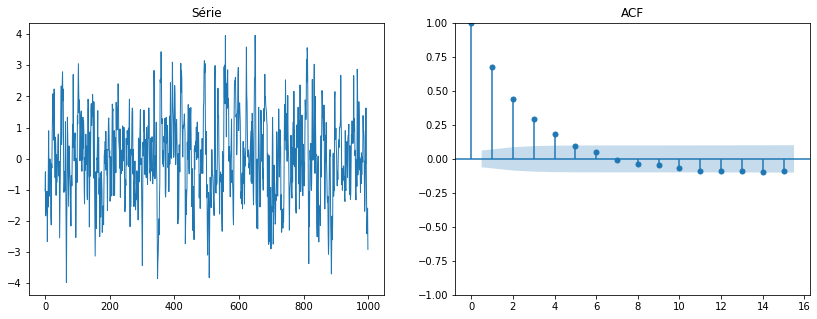

In [11]:
#@markdown  
fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(14,5))
ax1.plot(simulated_data,linestyle='solid',alpha=1,lw=1)
ax1.title.set_text('Série')
y=plot_acf(simulated_data, lags=15,ax=ax2, title="ACF")


Note que a correlação que considera valores sucessivos ($Y_t$ e $Y_{t-1}$, ou seja, $lag=1$) é de, aproximadamente, 0,7 e essas correlações decaem exponencialmente quando analisadas as associações entre valores mais distantes. Observa-se que para valores "muito" distantes no tempo (lags >7) a correlação é zero estatísticamente falando. 

Cuidado novamente na interpretação deste gráfico uma vez que há um efeito "bola de neve" nas correlações, por exemplo, se um valor no instante $t$ está correlacionado com o valor do instante anterior ($t-1$), então, por sua vez o valor do instante ($t-1$) está correlacionado com seu instante $t-2$. Por tanto, temos que o valor no instante $t$ também está correlacionado com o instante $t-2$. 

**Observação!** Recomenda-se analisar o ACF de **série estacionárias**. As séries **não estacionárias** possuem um ACF com decaimento muito lento e não é possível analisar seus valores uma vez que as tendências e/ou sazonalidades não permitem estudar se de fato valores distantes $k$ períodos de tempo estão relacionados ou não.

### Função de autocorrelação parcial (PACF)

As autocorrelações parciais são usadas para mensurar o grau de associação (correlação) entre os valores $Y_{t}$ e $Y_{t-k}$, quando os efeitos das outras defasagens são removidos.

O gráfico PACF para a série simulada é dado a seguir:

/usr/local/lib/python3.9/dist-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


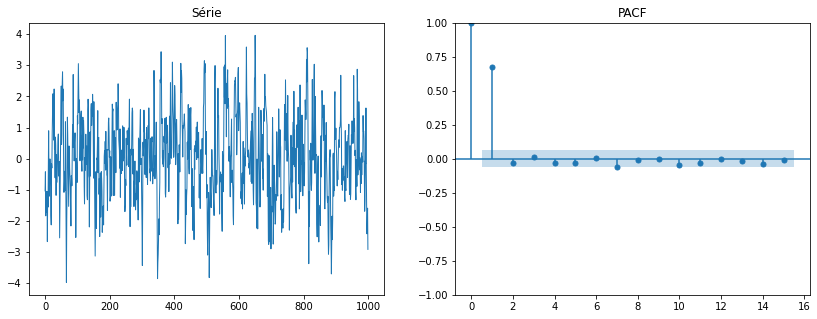

In [12]:
#@markdown  
fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(14,5))
ax1.plot(simulated_data,linestyle='solid',alpha=1,lw=1)
ax1.title.set_text('Série')
y=plot_pacf(simulated_data, lags=15,ax=ax2, title="PACF")


Observa-se que somente a correlação do lag=1 é significativamente diferente de zero. Em um modelo de previsão podemos entender este resultado como  o valor da série no instante $"t"$ pode ser previsto usando a informação contida no instante $"t-1"$.

## Modelos Autoregressivos
Denotação: AR(p), modelo autoregressivo de ordem p. 

A estrutura dos modelos AR e, portanto, suas previsões são baseadas na modelagem da dependencia serial dos dados. Seja $Y_t$ o valor da série no instante $t$, os modelos AR(p) definem que $Y_t$ pode ser estimado por meio de uma combinação linear de $p$ valores passados da série mais um erro, no qual se incorpora tudo aquilo que não é explicado pelo histórico considerado. Assume-se que esses erros são independentes e se desenvolvem de forma aleatória em torno de zero com variância constante. O modelo AR(p) é dado por



$$Y_t=\phi_1Y_{t-1}+ \phi_2Y_{t-2}+...+ \phi_pY_{t-p} +e_t,$$

em que $\phi_1,...,\phi_p$ são valores a serem estimados, usaremos a biblioteca *statsmodels* de pyhton para isto, e $e_t$ um ruído branco que segue, geralmente, uma distribuição Normal. Para garantir estacionariedade (média e variância finita e invariantes no tempo) restrições sobre seus parâmetros devem ser adotadas, ver mais detalhes em Morettin e Toloi (1985). 

Uma vantagem de você implementar os modelos AR(p) é poder mensurar o "peso" ($\phi_i$) que um valor defasado ($Y_{t-i}$) representa na estimação do valor atual (instante $t$) da série $(Y_t)$. Assim, você pode perceber que para prever o valor de amanhã, em uma série diária, os valores de ontem e de há uma semana são importantes, porém, o valor de ontem pode ser, por exemplo, 5 vezes mais "informativo".

**Exemplo**. O modelo AR(1) é dado por:

$$Y_t =\phi_0+\phi_1 Y_{t-1} +e_t,$$


Para que o processo seja estacionário (média e variância finita) é necessário que $|\phi_1|<1$. Finalmente, a função de autocorrelação (ACF) de um modelo AR(1) é da forma $$\rho_k=\phi_1^k, k≥0$$  em que $\rho_k$ representa a autocorrelação entre as observações com defasagens $k$ e $k−1$. Assim, para valores consecutivos ($Y_t$ e $Y_{t-1}$) a correlação entre eles é de $\phi_1$. Veremos, via simulação, que conforme $k$ aumenta a ACF decai exponencialemnte quando $\phi_1>0$. 
Analisar a função ACF é importante para identificar os modelos AR.



### Simulando modelos AR(p)

Vamos simular aqui um processo autorregressivo AR(1) com diferentes valores de $\phi_1$ para visualizar seu comportamento e suas funções de autocorrelação (ACF) e autocorrelação parcial (PACF). Destaca-se que para que a série seja estacionária é necessário que $|\phi_1|<1$ para mais detalhas ver Morettin(1983).


In [13]:
#@markdown 

def plot_acf_pacf_ar(phi=0.7):
  fig, (ax1, ax2, ax3) = plt.subplots(1, 3,figsize=(16,5))
  np.random.seed(2000)
  ar1 = np.array([1,-phi])
  simulated_data_1 = ArmaProcess(ar1).generate_sample(nsample=1000)

  ax1.plot(simulated_data_1,linestyle='solid',alpha=1,lw=1)
  ax1.title.set_text('Série')
  plot_acf(simulated_data_1, ax=ax2, title="ACF")
  y=plot_pacf(simulated_data_1, ax=ax3, title="PACF")


In [14]:
import ipywidgets as widgets
w = widgets.interactive(plot_acf_pacf_ar, phi=(-0.99, 0.99, 0.1))
display(w)

interactive(children=(FloatSlider(value=0.7, description='phi', max=0.99, min=-0.99), Output()), _dom_classes=…

A série simulada tem 1.000 observações com média zero. Nota-se que os valores se desenvolvem de forma aleatória em torno da média com variância constante, comportamento esperado uma vez que $\phi_1 \in (0,1)$. A função ACF mostra que a correlação serial decresce de forma exponencial cuja correlação amostral entre os valores dos instantes $t$ e $t-1$ é de, aproximadamente, $\phi_1$ e na função PACF observa-se que somete o lag 1 é significativamente diferente de zero cujo valor cujo o valor amostral corresponde, aproximadamente, ao valor de $\phi_1$ selecionado na simulação. 

Na prática, recomenda-se analisar a função PACF para identificar o modelo AR(p) uma vez que  somente os $p$ primeiros lag, correlações entre instantes $t$ e $t-i, i=1,2,...,p$ são significativamente diferente de zero. A função ACF destes modelos apresentam  um decresciemento exponencial e/ou comportamentos parecidos com o das funções seno e coseno dependendo do sinal do parâmetro $\phi_1$.

Na identificação de um modelo AR($p$) uma abordagem comumente usada consiste em analisar a função de autocorrelação parcial (FACP) para sugerir um possível intervalo de valores de $p$. Outra alternativa, amplamente usada na prática, baseia-se no uso de algum critério de informação, por exemplo, AIC e/ou BIC. O procedimento consiste em definir $k$ possíveis valores de $p$ ajustar os $k$ modelos AR e selecionar aquele que apresentou o menor valor de AIC e/ou BIC. Mas detalhes podem ser encontrados em Morettin(1983).

Nos exemplos anteriores fizemos uso da PACF para confirmar que ao avaliar tal função para os modelos AR simulados chegaríamos na correta defasagem do modelo.

## Modelos de Médias móveis
Denotação: MA(q), modelos de médias móveis de ordem q. 

Na estrutura dos modelos MA, assume-se que a série temporal pode ser gerada por meio de uma combinação linear de erros aleatórios. Seja $Y_t$ o valor da série no instante $t$, temos

$$Y_t=a_t-\theta_1e_{t-1}- \theta_2e_{t-2}-...- \theta_qe_{t-q},$$

em que $\theta_1,...,\theta_q$ são parâmetros a serem estimados, usaremos a biblioteca $stastmodels$ de pyhton para isto e $e_t$ um ruído branco que segue, geralmente, uma distribuição Normal. Um modelo MA(1) é equivalente a um modelo AR de ordem infinita. Assim, para muitas séries encontradas na práticas, se quisermos um modelo AR com um número não muito grande de parâmetros, a inclusão de termos de médias móveis é uma solução adequada. Na seguinte seção, você vai ver a estrutura dos modelo ARMA que consideram termos AR e de MA. 

Uma característica interessante de um processo MA(q) é sua função ACF cujos valores são iguais a zero para "lags"maiores do que $q$. Assim, você poderia pensar em implementar um modelo MA(1) para modelar sua série se, por exemplo, você verifica que o valor da série no instante t, $Y_t$ só depende (está correlacionado) com o valor imediatamente anterior ($Y_{t-1}).$

**Exemplo.** O modelo MA(1) é dada por:

$$Y_t= \theta_0 -\theta_1 e_{t-1}+e_t$$

Neste modelo não há restrições dos parâmetros para garantir estacionaridade (média e variância finita). De fato, a média e variância dos processos de médias móveis sempre serão constantes. A função de autocorrelação, ACF,  é dada por:
$$\rho_1=\frac{\theta_1}{(1+\theta_1^2)}$$ e $$\rho_k=0, k>1.$$


O comportamento que você observa na ACF do modelo MA(1)  também se observa nos modelos MA(q) com $q>1$, isto é, os únicos valores de $\rho_k$ diferentes de zero são as correlações referentes às primeiras $q$ defasagens. Desta forma, podemos usar a função de autocorrelação como uma boa alternativa para definir a defasagem ($q$) de um processo de médias móveis (MA($q$)).


 

### Simulando modelos MA(q)

In [15]:
#@markdown 

def plot_acf_pacf_ma(theta=0.8):
  fig, (ax1, ax2, ax3) = plt.subplots(1, 3,figsize=(16,4))
  np.random.seed(2000)
  ar1 = np.array([1])
  ma1 = np.array([1,theta])
  simulated_data_1 = ArmaProcess(ar1,ma1).generate_sample(nsample=1000)

  ax1.plot(simulated_data_1)
  ax1.title.set_text('Série')
  plot_acf(simulated_data_1, ax=ax2, title="ACF")
  y=plot_pacf(simulated_data_1, ax=ax3, title="PACF")


In [16]:
import ipywidgets as widgets

w = widgets.interactive(plot_acf_pacf_ma, theta=(-0.9, 0.9, 0.1))
display(w)

interactive(children=(FloatSlider(value=0.8, description='theta', max=0.9, min=-0.9), Output()), _dom_classes=…

As séries simuladas têm 1.000 observações com média zero. Nota-se que os valores da série se desenvolvem de forma aleatória em torno da média. Nestas simulações consideramos que $\theta \in (0,1)$. No entanto, verifiquem que esse comportamento se mantêm para outros valores fora desse intervalo.

Observa-se na função ACF amostral que somete o lag 1 é significativamente diferente de zero. Vale salientar que o valor téorico de $\phi_1$ é $\frac{\theta_1}{1+\theta_1^2}$. Por fim, nota-se que a função PACF decresce exponencialmente cujos valores variam de positivo a negativo. 

Na prática, recomenda-se analisar a função ACF para identificar o modelo MA(q). Essa conclusão é diferente do que encontramos para os modelos autorregressivos (AR) onde a função de autocorrelação parcial (PACF) permite definir a defasagem do processo.

## Modelos Autoregressivos e de médias móveis
Denotação: ARMA(p,q). Modelos ARMA de ordem p e q.

Se considerarmos um modelo formado pela parte Autoregressiva (AR) e de Médias móveis (MA), vamos ter um modelo mais geral de séries temporais nomeado ARMA. Na estrutura dos modelos ARMA(p,q) incorporam-se $p$ valores defasados da série e $q$ valores defasados de erros aleatórios. Seja  $Y_t$ o valor da série no instante $t$, temos

$$Y_t=\phi_1Y_{t-1}+ \phi_2Y_{t-2}+...+ \phi_pY_{t-p}-\theta_1e_{t-1}- \theta_2e_{t-2}-...- \theta_qe_{t-q}+e_t,$$

em que $e_t$ é ruído branco com média zero. Na prática, incorporam-se termos de médias móveis para diminuir o número de termos autorregressivos no modelo e melhorar o ajuste.

**Exemplo**. O modelo ARMA(1,1) é dado por:

$$Y_t= \phi_0+ \phi_1 Y_{t-1}- \theta_1e_{t-1}+e_t$$

As restrições de estacionariedade são iguais às modelo AR(1), isto é, $|\phi_1|<1$. A função de autocorrelação, ACF, do modelo ARMA(1,1) se comporta muito semelhante à FAC do AR(1) exceto pelo fato que o seu decaimento inicia na defasagem 2.

### Simulação modelos ARMA (p,q)

In [17]:
#@markdown 
def plot_acf_pacf_arma(theta=0.3, phi=0.6):
  fig, (ax1, ax2, ax3) = plt.subplots(1, 3,figsize=(16,4))
  np.random.seed(2000)
  ar1 = np.array([1, -phi])
  ma1 = np.array([1,theta])
  simulated_data_1 = ArmaProcess(ar1,ma1).generate_sample(nsample=1000)

  ax1.plot(simulated_data_1)
  ax1.title.set_text('Série')
  plot_acf(simulated_data_1, ax=ax2, title="ACF")
  y=plot_pacf(simulated_data_1, ax=ax3, title="PACF")

In [18]:
import ipywidgets as widgets

w = widgets.interactive(plot_acf_pacf_arma, theta=(0.1, 0.9, 0.1), phi=(-0.9, 0.9, 0.1))
display(w)

interactive(children=(FloatSlider(value=0.3, description='theta', max=0.9, min=0.1), FloatSlider(value=0.6, de…

As séries simuladas têm 1.000 observações com média zero. Nota-se que se desenvolvem de forma aleatória em torno da média. Observa-se no exemplo, ARMA(1,1) com $\phi_1=0,6$ e $\theta_1=0,3$ que a correlação serial decresce exponencialmente e a função PACF mostra que os três primeiros lags são siginificativamente diferente de zero. O primeiro lag é um pouco maior que o valor de $\phi_1$.

Apesar dos modelos ARMA(p,q) serem combinações lineares de modelos AR(p) e MA(q), o comportamento das funções de autocorrelação e autocorrelação parcial não necessáriamente estarão em conformidade com o que estudamos para os modelos AR e MA. Desta forma, faz-se necessário o uso de critérios de seleção, por exemplo, o Akaike’s Information Criterion (AIC) e o Bayesian Information Criterion (BIC) para a seleção das ordens do modelo ARMA(p,q). Estes critérios mensuram de forma geral a perda de informação decorrente da modelagem, o modelo mais parcimonioso será aquele com menor valor de AIC e/ou BIC.


## Modelos Autoregressivos integreados e de médias móveis


Denotação: ARIMA(p,d,q). Modelos ARMA de ordem p e q com d diferenças.

Os modelos ARIMA são capazes de descrever o comportamento de séries estacionárias ou não estacionárias homogêneas, isto é, séries que não apresentam comportamentos explosivos. Uma característica dos processos estacionários homogênos é que a inclinção ou nível da série muda ao longo do tempo. Assim, se você deseja fazer previsões e/ou entender o comportamento dos dados ao longo do tempo os modelos ARIMA são uma boa opção.

Um exemplo de um processo não estacionário homogêneo é um processo AR(1) com $\phi_1=1$, chamado de passeio aleatório.

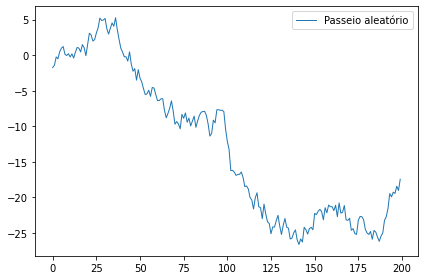

In [19]:
# Simulação de um passeio aleatório
ar1 = np.array([1,-1])
np.random.seed(100)
simulated_data_2 = ArmaProcess(ar1).generate_sample(nsample=200)

tspplot(simulated_data_2,label='Passeio aleatório')

Na aplicação dos modelos ARIMA(p,d,q) primeiro realizam-se $d$ diferenças para que a série se torne estacionária ($d=0$ indica que a série de interesse é estacionária e portanto não é necessário aplicar diferenças), $p$ indica o número total de termos defasados da série (parte AR) que serão considerados e $q$ o número total de termos defasados de erros aleatórios correspondente à parte de Médias móveis (MA) cuja interpretação é menos intuitiva. Seja $Y_t$ o valor da série no instante $t$, temos

$$W_t={\Delta^d Y_t}$$


$${W_t} =\phi_0+ {\phi_1 W_{t-1}+ \phi_2 W_{t-2}+...+\phi_p  W_{t-p}} +{\theta_1e_{t-1}+ \theta_2 e_{t-2}+...+ \theta_q e_{t-q}} + e_t , $$

em que $\phi_1,...,\phi_p, \theta_1,...,\theta_q$ são valores a serem estimados e, geralmente, o ruído branco, $e_t$, segue uma distribuição Normal. Na prática, incorporam-se, geralmente, termos de médias móveis para diminuir o número de termos autorregressivos no modelo e melhorar o ajuste. Quando $d=1$, temos que, $\Delta^1 Y_t= Y_t - Y_{t-1}$

**Exemplo** O modelo ARIMA(1,1,1) é dado por

$$W_t = Y_t-Y_{t-1}$$
$$W_t=\phi_1W_{t-1}-\theta_1e_{t-1}+e_t$$


Repare que, após aplicar uma diferença, é ajustado um modelo ARMA(1,1) à série diferenciada ($W_t$). A seguir, você encontrará os passos para ajustar um modelo ARIMA.

### Passos para ajustar um modelo ARIMA

<img src="https://github.com/Rogerio-mack/Temporal/raw/main/Figures/Fluxograma2.png" width=300 align="middle">



1. Verificar se a série é estacionária. Um procedimento simples consiste em plotar os valores observados da série ao longo do tempo e verificar se há tendências ou sazonalidadades (comportamentos de séries não estacionárias). Quando visualmente não é possível determinar se a série é ou não estacionária pode-se aplicar o teste de raizes unitárias Dickey-Fuller (Df) que será discutido nesta seção. Para eliminar tendências e tornar a série estacionária podem-se aplicar d diferenças (ou em alguns casos, ajustar retas de tendências por meio de polinômios)

2. Com a série estacionária, após d diferenças, selecionam-se possíveis valores de p e q com ajuda das funções ACF e PACF. 

3. Ajustam-se modelos ARIMA(p,d,q) com os valores de p, d e q definidos nos dois passos anteriores.

4. Para selecionar o melhor modelo, isto é, aquele que se ajusta melhor aos dados podem-se usar o critério de seleção AIC. Aquele modelo que apresentar o menor valor para este critério deve ser considerado.

5. Analisar os resíduos do modelo selecionado no passo 4. Deve-se verificar que os resíduos sejam independentes (não correlacionados), com média zero com variância constante, podem-se usar um gráfico de ACF e de linhas para checar estes pressupostos. Por fim, os resíduos devem seguir uma distribuição normal, pressuposto necessário para realizar previsões e construir intervalos de confiança. Aqui podem ser implementados um histogramas ou um gráfico QQ-plot.

### Teste de Estacionariedade 

Um Teste de Estacionariedade é um teste para verificar se uma série temporal é ou não estacionária de modo (estatisticamente) significativo. 

Existem vários testes estatísticos que permitem verificar se uma série é ou não estacionária. O teste **ADF Augmented Dickey-Fuller** é bastante popular devido a sua simplicidade e fácil implementação. Neste teste, verifica-se se a série temporal tem ou não uma tendência estocástica, isto é, se existe raiz unitária na série. Você pode buscar outros testes mais complexos que também testam a presença de tendências se for o caso.

De modo prático, as hipóteses consideradas neste teste são

$$H_0: \text{A série tem tendência estocástica}$$
$$H_0: \text{A série não tem tendência estocástica}$$

Se $p-value \lt 0.05$ rejeita-se $H_0$ ao nível de significância de 5% e dizemos que há evidências amostrais suficientes para dizer que a série é estacionária. Caso contrário, dizemos que a série é não estacionária.

**Exemplo.** Vamos aplicar o teste para verificar estatísticamente que a série Exportação trimestral de bens e serviços no Brasil é de fato não estacionária.

In [20]:
from statsmodels.tsa.stattools import adfuller

result = adfuller(df1.Exportações)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic: 1.459004
p-value: 0.997366


Note que o valor-p é maior que 0,05, assim, há evidência estatística para dizer que a série é não estacionária. A implementação deste teste é recomendada quando as tendências não são muito claras e não pode ser deduzido graficamente se a série é ou não estacionária.

Nos seguintes exemplos serão ajustados modelos ARIMA

### Exemplo 1

Vamos ajustar a série mensal do preço médio de venda no atacado de óleo de soja refinado (20 unidades) no estado de Paraná. Período de análise: janeiro de 1997 a dezembro de 2019. Valores em Reais (R$). Dados obtidos do site: https://www.agricultura.pr.gov.br/deral/precos.


In [21]:
df=pd.read_csv(path+'series_oleo_soja.csv', delimiter=';', decimal=",")
df.index = pd.date_range(start='1/1/1997', end='12/31/2019', freq='M')

,ano,mês,valor
1997-01-31,1997,janeiro,15.17
1997-02-28,1997,fevereiro,15.49
1997-03-31,1997,março,15.73
1997-04-30,1997,abril,15.56
1997-05-31,1997,maio,15.65


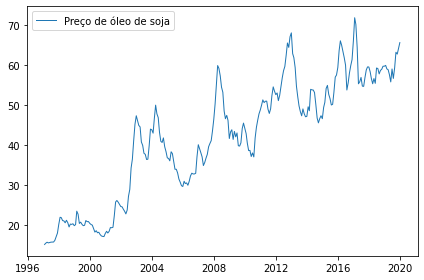

In [22]:
fig, ax = plt.subplots()

tspplot(df.valor,label='Preço de óleo de soja',ax=ax)
tspdisplay('df.head()')

Os preços variam entre 15,17 reias( registrado em abril de 1997) e 71,77 reais (valor atinguido em setembro de 2019). O interesse neste exercício é mostrar como ajustar uma serie usando os modelos ARIMA(p,d,q) visando fazer previsões a curto prazo.

Repare que os preços de venda no atacado de óleo de soja refinado apresentam uma tendência crescente ao longo do período de estudo e também um comportamento aparentemente sazonal. A seguir, apresenta-se a função ACF da série.

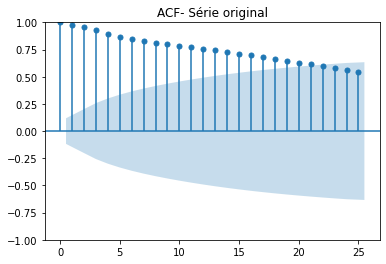

In [23]:
# Acf série original
y=plot_acf(df.valor, title="ACF- Série original")

Repare que há um decrescimento lento na função ACF, esse comportamento é esperado uma vez que a série não é estacionária. Para eliminar a tendência e tornar a série estacionária vamos tomar uma diferença e, posteriormente, vamos analisar a sua função ACF e PACF para definir possíveis valores de $p$ e $q$ do modelo ARIMA.

/usr/local/lib/python3.9/dist-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


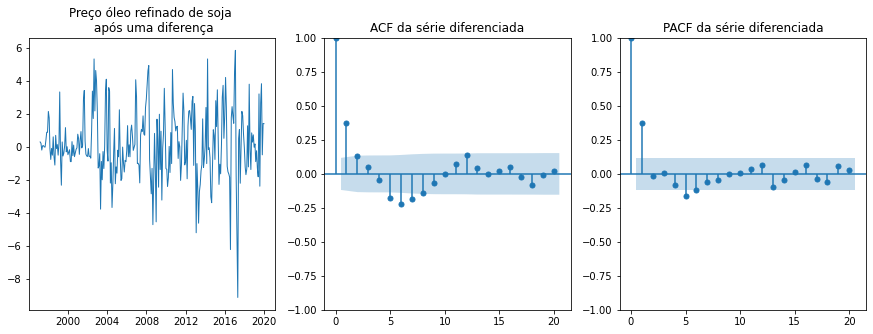

In [24]:
# Analisando o ACF
fig, (ax1, ax2, ax3) = plt.subplots(1, 3,figsize=(15,5))

ax1.plot(df.index, df.valor.diff(),linestyle='solid',alpha=1,lw=1)
ax1.set_title('Preço óleo refinado de soja \n após uma diferença')

y1=plot_acf(df.valor.diff().dropna(), lags=20, ax=ax2, title="ACF da série diferenciada")
y2=plot_pacf(df.valor.diff().dropna(),ax=ax3, lags=20, title="PACF da série diferenciada");

Note que a série diferenciada se desenvolve, aparentemente, de forma aleatória em torno de zero com menor variabilidade no começo da série, isto decorre da pouca variação dos preços nos primeiros anos. Vamos aplicar o teste DF para verificar a estacionariedade da série diferenciada.

In [25]:
result = adfuller(df.valor)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic: -1.445113
p-value: 0.560468


Como o valor-p é maior que 0,05 podemos assumir que a série diferenciada é estacionária, assim, para verificar os possíveis valores de $p$ e/ou $q$ que podem ser implementados no modelo ARIMA(p,d,q) vamos analisar as funções ACF e PACF da série após uma diferença. Na função PACF observa-se que seria interessante considerar no modelo a informação defassada dos lags 1, 5 e 6 uma vez que são estatísticamente diferente de zero (estão fora do intervalo de confiança). Assim, serão ajustados modelos ARIMA(p,d,q) com $d=1 $ e $p$ e $q$ no intervalo de 0 a 6. Os termos de médias móveis serão considerados para tentar melhorar o ajuste do modelo. Para selecionar o "melhor" modelo vamos considerar o critério AIC. 
A seguir, apresenta-se o AIC dos modelos ajustados, neste passo vamos deixar o último ano da série para verificar a acurácia do modelo para fazer previsões.

In [26]:
# Separando a série: treinamento e teste

a=len(df.valor)-12
train = df.valor[:a]
test = df.valor[a:]

In [ ]:
# Valores de AIC
import itertools

for i, j in itertools.product(range(7), range(7)):
  print("AIC do modelo","ARIMA(",i,", 1 ,",j,"):",
        round(ARIMA(train, order=(i, 1, j),
                    enforce_stationarity=True,
                    enforce_invertibility=True).fit(method_kwargs={'maxiter':700}).aic,4))

O modelo ARIMA (2,1,3) apresenta o menor valor de AIC. Assim, vamos analisar os resíduos deste modelo para verificar se há alguma violação dos pressupostos. Lembre-se de que o último ano da série não foi considerado no ajuste do modelo e suas observações serão usadas para verificar a acurácia do modelo para fazer previsões. 

Observação: Você pode reparar que alguns modelos não convergem isto porque usando esses de $p$ e $q$ não se garante a estacionaridade ou invertibilidade do modelo ARIMA. 

In [28]:
# Ajustando o modelo ARIMA

model=ARIMA(train, order=(2, 1, 3))
print(model.fit().summary())

                               SARIMAX Results                                
Dep. Variable:                  valor   No. Observations:                  264
Model:                 ARIMA(2, 1, 3)   Log Likelihood                -535.064
Date:                Mon, 27 Mar 2023   AIC                           1082.129
Time:                        18:28:12   BIC                           1103.562
Sample:                    01-31-1997   HQIC                          1090.742
                         - 12-31-2018                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.5950      0.051     31.137      0.000       1.495       1.695
ar.L2         -0.9437      0.047    -20.063      0.000      -1.036      -0.852
ma.L1         -1.2267      0.085    -14.494      0.0

A série mensal Preço de óleo de soja foi ajustada com 264 observações. Ao nível de significância de 5% todos os parâmetros são estatísticamente diferente de zero (valores-p: (P>|z|)< 0.05). Assim, o modelo ajustado fica dado pela expressão:

<center> $Y_t= Y_{t-1}+1,595 (Y_{t-1}-Y_{t-2})-0,9437(Y_{t-2}-Y_{t-3})-1,2367 a_{t-1}+0,4681 a_{t-2}+ 0,2681 a_{t-3} +a_t$,</center>


em que $Var(a_t)=3,4141$. A seguir, vamos realizar uma análise dos resíduos deste modelo. Este passo permite realizar previsões com intervalos de confiança confiáveis, isto deve-se ao fato que os intervalos são construíudos assumindo normalidade.

#### Análise de resíduos

In [29]:
# Resíduos
res=model.fit()
res_standard=(res.resid-res.resid.mean())/np.sqrt(res.resid.var())#standardized residuals

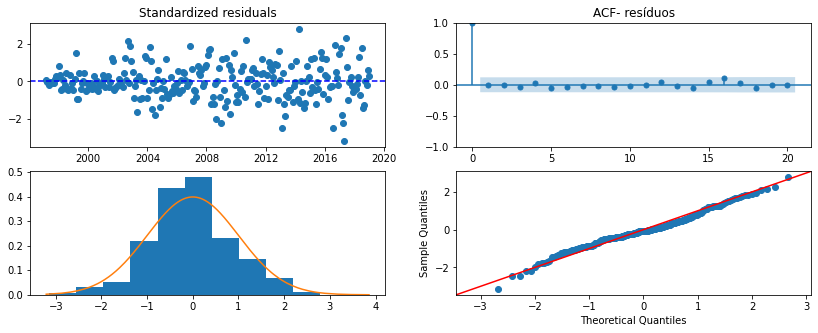

In [30]:
# Gráficos do ajuste
#@markdown 

fig,axs = plt.subplots(2, 2,figsize=(14,5))

axs[0,0].scatter(df.index[1:a], res_standard[1:a]) 
axs[0,0].axhline(y=0, color='b', linestyle='--')
axs[0,0].set_title('Standardized residuals')

x=plot_acf(res.resid, lags=20, ax=axs[0,1], title="ACF- resíduos");

axs[1,0].hist(res_standard[1:a], density=True);
x=np.sort(np.random.normal(0, 1, 1000))
axs[1,0].plot(x, stats.norm.pdf(x, 0, 1))
x1=sm.qqplot(res_standard[1:a], line ='45', ax=axs[1,1])


Note que os resíduos seguem, aproximadamente, uma distribuição normal e são independentes, isto é, toda a informação continda no histórico da série foi considerado no modelo ARIMA (ver ACF, todos os lags são estatísticamente zero). Por fim, em uma nova análise recomenda-se tentar transformar os dados, por exemplo, aplicar a função logaritmo para tentar ajustar a maior variabilidade que se observa nos resíduos nos últimos anos da série.

#### Forecast
Vamos fazer as previsões para o último ano da série, com intervalo de confiança de 95%, para analisar a habilidade do modelo ARIMA (2,1,3) para fazer previsões

In [45]:
#forecast h=12  
forecast = model.fit().get_forecast(12)
forecast.predicted_mean

# Previsões com intervalos de confiança de 95%
fc_series = pd.Series(forecast.predicted_mean, index=test.index)
lower_series = pd.Series(forecast.conf_int(alpha = 0.05)["lower valor"], index=test.index)
upper_series = pd.Series(forecast.conf_int(alpha = 0.05)["upper valor"], index=test.index)

In [48]:
df_prev=pd.DataFrame({"Previsões":fc_series, 
              "Limite Inferior IC 95%":lower_series,
              "Limite Superior IC 95%":lower_series})
tspdisplay('df_prev')

,Previsões,Limite Inferior IC 95%,Limite Superior IC 95%
2019-01-31,58.576791,54.955306,54.955306
2019-02-28,57.573033,51.435592,51.435592
2019-03-31,57.217222,49.068931,49.068931
2019-04-30,57.596997,47.642999,47.642999
2019-05-31,58.538511,46.964389,46.964389


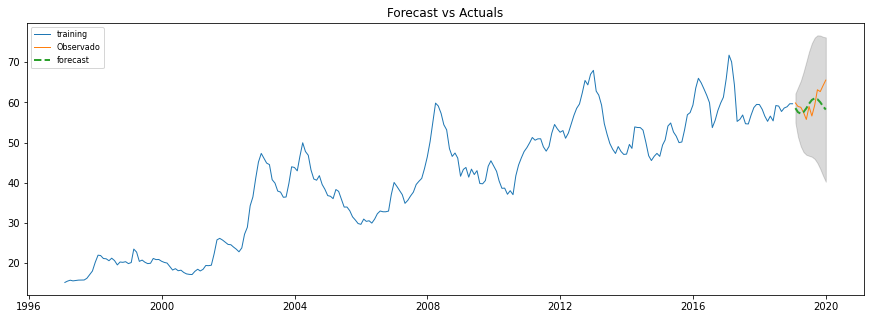

In [59]:
#@markdown 

plt.figure(figsize=(15,5))

plt.plot(train, label='training',linestyle='solid',alpha=1,lw=1)
plt.plot(test, label='Observado',linestyle='solid',alpha=1,lw=1)
plt.plot(fc_series, label='forecast',linestyle='dashed',alpha=1,lw=2)
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.15)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)

plt.show()


Você considera que as previsões são boas? 

Vale ressaltar que o modelo ARIMA (2,1,3) está considerando que o instante $t$ está sendo influenciado (correlacionado) pelos valores da série nos instantes $t-1$ e $t-2$. Assim, quando fazemos a previsão para janeiro de 2019 temos informação(valor observado) da série do mês anterior, dezembro de 2019 $(t-1)$ e de novembro de 2019 $(t-2)$. No entanto, quando fazemos a previsão para fevereiro de 2020 já não temos informação (observada) do mês anterior, só temos um valor previsto pelo modelo, por esse motivo as previsões mais distantes apresentam maior erro (o intervalo de confiança aumenta) e seus valores tendem tendem a acompanhar o comportamento da tendência da série (modelada pela diferença). 

Para avaliar o desempenho do modelo para fazer previsões vamos usar algumas métricas discutidas no capítulo 1.

In [ ]:
# acuracia

def forecast_accuracy(forecast, actual):
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
    me = np.mean(forecast - actual)             # ME
    mae = np.mean(np.abs(forecast - actual))    # MAE
    mpe = np.mean((forecast - actual)/actual)   # MPE
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE
    return({'mape':mape, 'me':me, 'mae': mae, 
            'mpe': mpe, 'rmse':rmse})

forecast_accuracy(forecast.predicted_mean, test.values)

{'mape': 0.040414480126268505,
 'me': -2.1143135096585817,
 'mae': 2.50286380419483,
 'mpe': -0.033556998652704895,
 'rmse': 3.21017231451055}

Observe que o erro médio abstoluto (MAE) das previsões é de 2.5 reais. 

**Observação** Na prática, podemos usar alguma dessas métricas junto com o critério AIC para escolher o "melhor" modelo.

#### Forecast one step 

É interessante analisar o desempenho do modelo para fazer previsões se atualizamos na base de dados a cada valor observado. As previsões melhoram?


In [65]:
# forecast atualizando cada valor observado
X = df.valor
size = 263
train, test = X[0:size], X[size:len(X)]
history = [x for x in train]
predictions = list()
low1= list()
upper1= list()
forecast_one_step=pd.DataFrame()


for t in range(len(test)):
  model= ARIMA(history,order=(2,1,3))
  model_fit=model.fit()
  forecast = model_fit.get_forecast(1)
  yhat=forecast.predicted_mean
  low=forecast.conf_int(alpha = 0.05)[0,0]
  upper=forecast.conf_int(alpha = 0.05)[0,1]
  predictions.append(yhat)
  low1.append(low)
  upper1.append(upper)
  obs= test[t]
  history.append(obs)

forecast_one_step["forecast"]=predictions
forecast_one_step["low"]=low1
forecast_one_step["upper"]=upper1
forecast_one_step.index=test.index

tspdisplay('forecast_one_step')

,forecast,low,upper
2018-12-31,[58.826757234886934],55.200385,62.453129
2019-01-31,[58.57679089989537],54.955306,62.198275
2019-02-28,[59.44140936520137],55.823085,63.059734
2019-03-31,[58.688440995126825],55.076703,62.300179
2019-04-30,[59.28738401697057],55.682432,62.892336


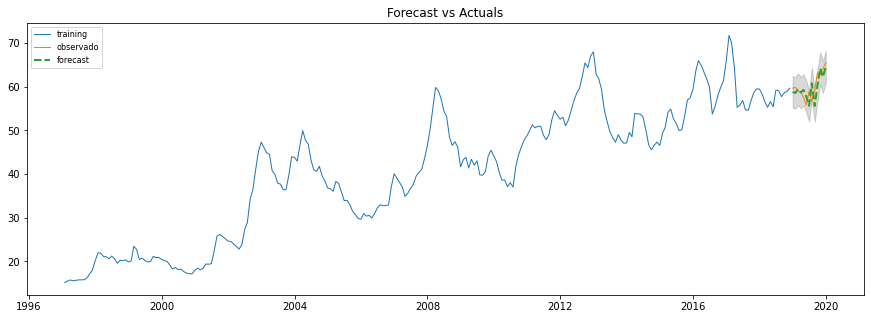

In [67]:
#@markdown 

plt.figure(figsize=(15,5))

plt.plot(train, label='training',linestyle='solid',alpha=1,lw=1)
plt.plot(test, label='observado',linestyle='solid',alpha=1,lw=1)
plt.plot(forecast_one_step["forecast"], label='forecast',linestyle='dashed',alpha=1,lw=2)
plt.fill_between(forecast_one_step.index, forecast_one_step["low"], forecast_one_step["upper"], color='k', alpha=.15)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

Nota-se que os valores previsto e observados são muito próximos quando atualizamos os valores conforme observados. O erro médio abstoluto (MAE) das previsões diminuiu para 1,92 reais.

In [68]:
print("MAE:", np.mean(np.abs(forecast_one_step["forecast"] - test)))

MAE: [1.92168233]


#### **Autoarima**

Podemos implementar a biblioteca pmdarima para selecionar o "melhor" modelo usando algum critério de informação. 

**Cuidado**! Este pacote geralmente apresenta alguns erros uma vez que o pacote pmdarima sobrepõe a instalação do statsmodel, isso pode gerar alguns problemas. Recomendo, portanto, que você empregue programas separados para utilizar em separado o statsmodel e o pmdarima, o tenha cuidado no uso conjunto.

In [ ]:
!pip install pmdarima

In [ ]:
import pmdarima as pm
model_auto = pm.auto_arima(df.valor, d=1,information_criterion="aic",trace=1,stepwise=False)
print(model_auto.summary())

Note que chegamos no mesmo modelo ARIMA(2,1,3).

### Exemplo 2

Vamos o analisar o conjunto de dados que descreve a produção mensal de leite (em libras por vaca) ao longo de 13 anos (1962-1975).

,value
date,
1962-01-01,589
1962-02-01,561
1962-03-01,640
1962-04-01,656
1962-05-01,727


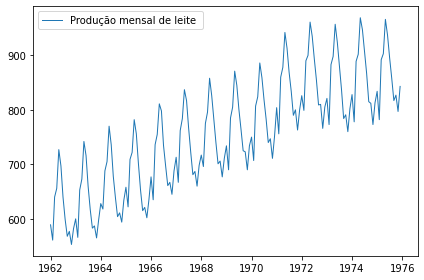

In [80]:
df_2=pd.read_csv(path+'milk-production.csv', parse_dates=['date'], index_col='date')


fig, ax = plt.subplots()
tspplot(df_2,label='Produção mensal de leite ',ax=ax)
tspdisplay('df_2')

A seguir apresenta-se a série temporal e sua decomposição: tendência, sazonalidade. Os resíduos também são apresentados no último gráficos que representam os valores da série sem tendência nem sazonalidade. Nestes resíduos encontra-se toda a correlação serial que será modelada usando os termos autorregressivos e de médias móveis. Nota-se que a produção mensal de leite apresenta uma tendência crescente e um comportamento sazonal que se repete a cada 12 meses.

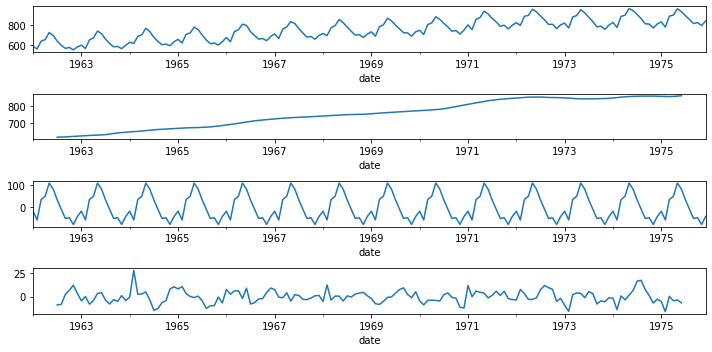

In [83]:
# Decomposição da série

res=seasonal_decompose(df_2)

fig, (ax1,ax2,ax3,ax4) = plt.subplots(4,1, figsize=(10,5))
res.observed.plot(ax=ax1)
res.trend.plot(ax=ax2)
res.seasonal.plot(ax=ax3)
res.resid.plot(ax=ax4)

plt.tight_layout()
plt.show()

Para modelar a tendência na série vamos diferenciar a série $$ \Delta Y_t = Y_t -Y_{t-1} $$ 
E para modelar a sazonalidade pode-se realizar uma diferença sazonal de defassagem 12, isto é, 
$$\Delta^{12} Y_t = Y_t -Y_{t-12} $$


A função de ACF da série original mostra que há um comportameto sazonal, após uma diferença observa-se que o ACF da série apresenta altos valores nos lags multiplos de 12 mostrando que há uma forte dependencia anual

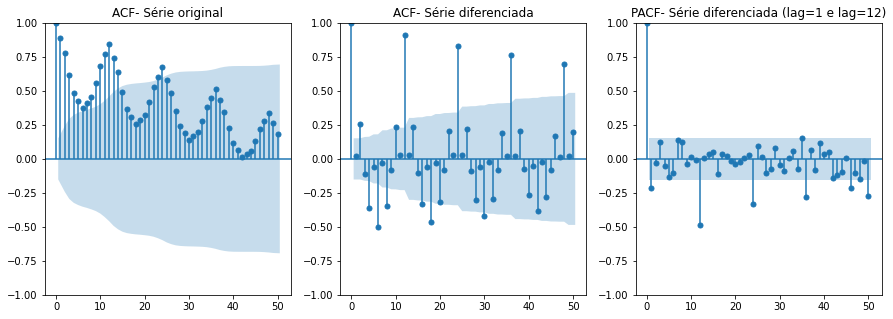

In [86]:
# Aplicar diferenças para eliminar tendências e modelar a sazonalidade

fig, (ax1, ax2, ax3) = plt.subplots(1, 3,figsize=(15,5))

y=plot_acf(df_2, lags=50, ax=ax1, title="ACF- Série original")
y1=plot_acf(df_2.diff().dropna(), lags=50, ax=ax2, title="ACF- Série diferenciada")
y2=plot_pacf(df_2.diff().diff(12).dropna(), lags=50, ax=ax3, title="PACF- Série diferenciada (lag=1 e lag=12)")

Nota-se no gráfico do acf da série original que o decaimento é lento indicando que a série não é estacionária. Além disso, observa-se um comportamento sazonal na correlação serial comportamento esperado em séries sazonais. No gráfico do ACF da série após uma diferença (lag=1) observa-se que os dados estão altamente correlacionados com defasagens de ordem 12, comportamento observado na decomposição da série. Por fim, no gráfico PACF da série diferenciada para eliminar a tendência e sazonalidade observa-se que seria interessante considerar considerar num modelo ARIMA o efeito dos valores com defassagem 1, 12, 24 e 36.

Implementaremos neste exemplo o modelo SARIMA que permite incluir termos autorregressivos e de médias móveis sazonais. Deixaremos o último ano da série para avaliar a acuracia do modelo para fazer previsões. 

Vamos ajustar um modelo SARIMA(1,1,0)(3,1,0,12) considerando a análise da função PACF. Neste modelo estamos considerando que o instante $t-1$ deve ser considerado na modelagem ($p=1$), vamos realizar uma diferença para eliminar a tendência ($d=1$) e não estamos consideramos termos de médias móveis ($q=0$). Por fim, os últimos valores do modelo SARIMA indicam que vamos considerar um comportamento sazonal que se repete a cada 12 meses, o $P=3$ indica que os termos $(t-1(12)),(t-2(12))$ e $(t-3(12))$ serão considerados no modelo, $D=1$ indica que será realizada uma diferença de ordem 12 e $Q=0$ indica que não serão considerados termos de médias móveis sazonais.

In [87]:
# Treinamento e teste 
train = df_2.iloc[:len(df_2)-12]
test = df_2.iloc[len(df_2)-12:]  # último ano para testar

In [88]:
model = SARIMAX(train, order = (1, 1, 0),  seasonal_order =(3, 1, 0, 12)) # após uma diferença (lag=1 e lag=12)
result = model.fit()
print(result.summary());

/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


                                     SARIMAX Results                                      
Dep. Variable:                              value   No. Observations:                  156
Model:             SARIMAX(1, 1, 0)x(3, 1, 0, 12)   Log Likelihood                -488.068
Date:                            Mon, 27 Mar 2023   AIC                            986.136
Time:                                    20:20:04   BIC                           1000.950
Sample:                                01-01-1962   HQIC                           992.156
                                     - 12-01-1974                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2284      0.088     -2.599      0.009      -0.401      -0.056
ar.S.L12      -0.6498      0.082   

Nota-se que todas as estimativas dos parâmetros  de $Z_{t-1}$, $Z_{t-12}$, $Z_{t-24}$, $Z_{t-36}$ são estatísticamente diferente de zero. Vale destacar que para selecionar um "melhor" modelo pode-se considera um intervalo de valores para $p,q,P,Q$ e selecionar o modelo usando algum critério de decisão, por exemplo, AIC. 

A análise de resíduos confirma que o modelo está bem ajustado, não há tendências nos resíduos, eles se desenvolvem aleatoriamente em torno de zero, seguem aproximadamente uma distribuição normal e são não correlacionados como se observa na função ACF deles.

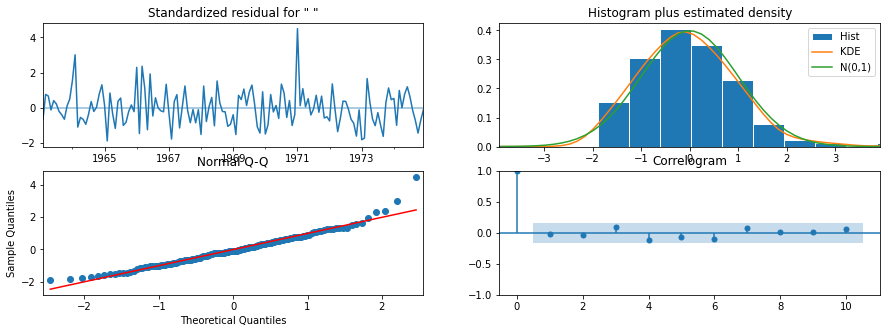

In [89]:
diag=result.plot_diagnostics()
diag.set_size_inches((15, 5))
fig.tight_layout()

Previsões para os próximos 12 meses foram realizadas para avaliar a acuracia do modelo. 

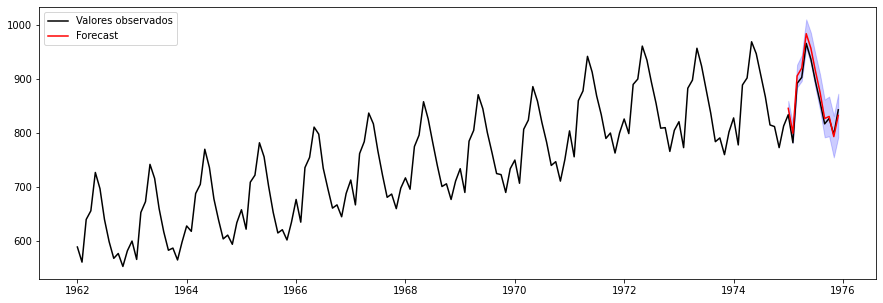

In [ ]:
#forecast 1 ano

#Checking prediction value with test
forecast = result.get_forecast(steps=len(test))
mean = forecast.predicted_mean
conf_int = forecast.conf_int()
d = mean.index

plt.figure(figsize=(15,5))
# Plot past  levels
plt.plot(df_2.index, df_2, label='Valores observados', color = 'black')
# Prediction Mean
plt.plot(d, mean, label='Forecast', color= 'red')
# Shade of space between  confidence intervals
plt.fill_between(d, conf_int.iloc[:,0], conf_int.iloc[:,1],
alpha=0.2, color= 'blue')
# Plot legend 
plt.legend()
plt.show()

Observa-se que as previsões acompanham o comportamento da série. O erro absoluto médio é de 65,59. 

In [ ]:
# acuracia do modelo
def forecast_accuracy(forecast, actual):
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
    me = np.mean(forecast - actual)             # ME
    mae = np.mean(np.abs(forecast - actual))    # MAE
    mpe = np.mean((forecast - actual)/actual)   # MPE
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE
    return({'mape':mape, 'me':me, 'mae': mae, 
            'mpe': mpe, 'rmse':rmse})

forecast=np.array(mean)
actual=np.array(test)
forecast_accuracy(forecast, actual)

{'mape': 0.07630612359830696,
 'me': 11.280260279412015,
 'mae': 65.5930359478068,
 'mpe': 0.01701488265973228,
 'rmse': 81.23824151852408}

### Exercício 3

O conjunto de dados Bike Sharing é uma Série bastante complexa embora com características bastante comuns a um grande número de problemas que envolvem demanda de produtos e serviços. A série de dados que temos interesse são os valores `cnt`, valores máximos de demanda de bicicletas por dia 


,timestamp,cnt,t1,t2,hum
0,2015-01-04,1039,4.0,3.5,100.0
1,2015-01-05,3161,10.0,9.0,93.0
2,2015-01-06,3534,11.0,11.0,88.0
3,2015-01-07,3618,10.0,7.0,87.0
4,2015-01-08,2351,12.0,12.0,88.0


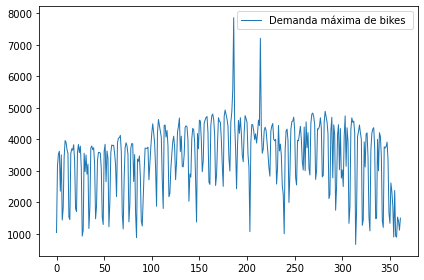

In [195]:
df_3=pd.read_csv(path+'dados_bike.csv')


fig, ax = plt.subplots()

tspplot(df_3.cnt,label='Demanda máxima de bikes ',ax=ax)
tspdisplay("df_3.iloc[:, 0:5]")

Repare que a série que estamos analisando não é estacionária. Assim, vamos realizar uma diferença.

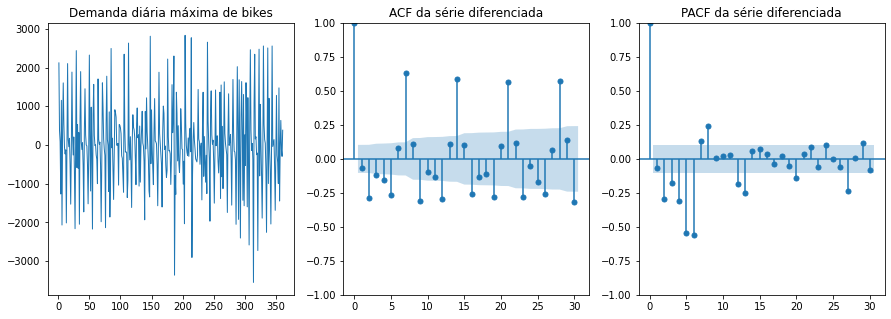

In [117]:
# Analisando o ACF
fig, (ax1, ax2, ax3) = plt.subplots(1, 3,figsize=(15,5))

ax1.plot(df_3.cnt.diff(),linestyle='solid',alpha=1,lw=1)
ax1.set_title('Demanda diária máxima de bikes')

y1=plot_acf(df_3.cnt.diff().dropna(), lags=30, ax=ax2, title="ACF da série diferenciada")
y2=plot_pacf(df_3.cnt.diff().dropna(),ax=ax3, lags=30, title="PACF da série diferenciada");

Observe que após uma diferença a série se desenvolve de forma aleatória em torno de zero. A função ACF sugere uma forte correlação a cada 7 dias. Vamos ajustar a série considerando um modelo ARIMA(7,1,q) e vamos encontrar o valor de q que minimiza o AIC.

In [215]:
test_size = int(0.2*len(df_3))
train_size = len(df_3) - test_size

# Create Training and Test
train = df_3.cnt[:train_size]
test = df_3.cnt[train_size:]

In [ ]:
# Valores de AIC
import itertools

for j in list(range(8)):
  print("AIC do modelo","ARIMA(",7,", 1 ,",j,"):",
        round(ARIMA(train, order=(7, 1, j),
                    enforce_stationarity=True,
                    enforce_invertibility=True).fit(method_kwargs={'maxiter':700}).aic,4))

Foi considerado o modelo ARIMA (7,1,3) uma vez que quando para valores de q maiores que 3 os modelos não convergem.

In [259]:
# Ajustando o modelo ARIMA
model=ARIMA(train, order=(7, 1, 3))
print(model.fit(method_kwargs={'maxiter':700}).summary())

                               SARIMAX Results                                
Dep. Variable:                    cnt   No. Observations:                  290
Model:                 ARIMA(7, 1, 3)   Log Likelihood               -2275.330
Date:                Mon, 27 Mar 2023   AIC                           4572.660
Time:                        22:15:49   BIC                           4612.991
Sample:                             0   HQIC                          4588.821
                                - 290                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4855      0.128     -3.791      0.000      -0.736      -0.234
ar.L2         -0.2839      0.101     -2.817      0.005      -0.481      -0.086
ar.L3         -0.9044      0.092     -9.818      0.0

In [256]:
# Resíduos
res=model.fit()
res_standard=(res.resid-res.resid.mean())/np.sqrt(res.resid.var())#standardized residuals

/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


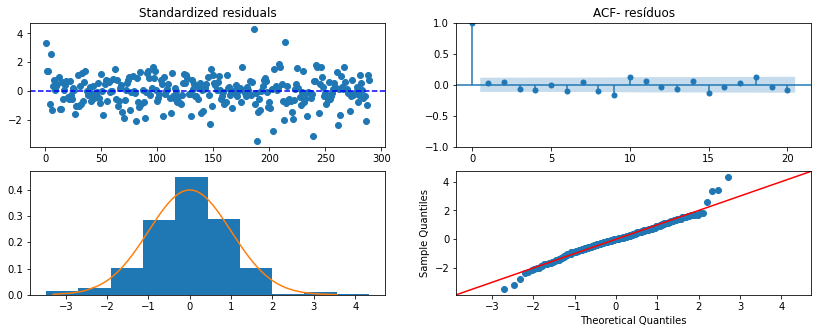

In [249]:
# Gráficos do ajuste
#@markdown 

a=train_size
train = df_3.cnt[:a]
test = df_3.cnt[a:]

fig,axs = plt.subplots(2, 2,figsize=(14,5))

axs[0,0].scatter(df_3.index[1:a], res_standard[1:a]) 
axs[0,0].axhline(y=0, color='b', linestyle='--')
axs[0,0].set_title('Standardized residuals')

x=plot_acf(res.resid, lags=20, ax=axs[0,1], title="ACF- resíduos");

axs[1,0].hist(res_standard[1:a], density=True);
x=np.sort(np.random.normal(0, 1, 1000))
axs[1,0].plot(x, stats.norm.pdf(x, 0, 1))
x1=sm.qqplot(res_standard[1:a], line ='45', ax=axs[1,1])


Podemos observar que os resíduos seguem aproximadamente uma distribuição normal e são independentes. É interessante considerar um modelo SARIMA que considere o comportamento sazonal da série que se repete a cada semana.

In [257]:
# forecast atualizando cada valor observado

history = [x for x in train]
predictions = list()
low1= list()
upper1= list()
forecast_one_step=pd.DataFrame()


for t in range(len(test)):
  model= ARIMA(history,order=(7,1,0))
  model_fit=model.fit()
  forecast = model_fit.get_forecast(1)
  yhat=forecast.predicted_mean
  low=forecast.conf_int(alpha = 0.05)[0,0]
  upper=forecast.conf_int(alpha = 0.05)[0,1]
  predictions.append(yhat)
  low1.append(low)
  upper1.append(upper)
  obs= test[test.index[t]]
  history.append(obs)

forecast_one_step["forecast"]=predictions
forecast_one_step["low"]=low1
forecast_one_step["upper"]=upper1
forecast_one_step.index=test.index

tspdisplay('forecast_one_step')

,forecast,low,upper
290,[4653.635025767848],3371.023937,5936.246115
291,[3771.390099956326],2472.879513,5069.900687
292,[4017.7956375653152],2719.076677,5316.514598
293,[2545.5353736987495],1249.022573,3842.048174
294,[2398.1915561782016],1100.810946,3695.572167


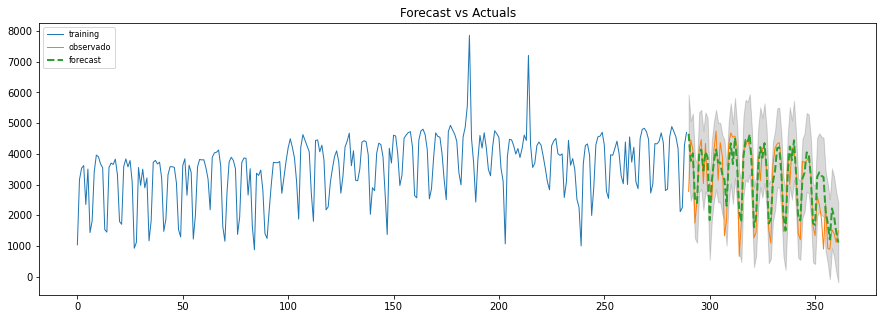

In [251]:
#@markdown 

plt.figure(figsize=(15,5))

plt.plot(train, label='training',linestyle='solid',alpha=1,lw=1)
plt.plot(test, label='observado',linestyle='solid',alpha=1,lw=1)
plt.plot(forecast_one_step["forecast"], label='forecast',linestyle='dashed',alpha=1,lw=2)
plt.fill_between(forecast_one_step.index, forecast_one_step["low"], forecast_one_step["upper"], color='k', alpha=.15)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [258]:
print("MAE:", np.mean(np.abs(forecast_one_step["forecast"] - test)))

MAE: [539.0229896]


# Reciclagem

Os modelos *Autoregressive Integrated Moving Average* (ARIMA) fornecem uma abordagem para a previsão de séries temporais incorporando na sua estrutura a correlação serial das observações e de erros aleatórios. Antes de introduzirmos os modelos ARIMA, devemos primeiro discutir o conceito de estacionariedade e a técnica de diferenciação de séries temporais.

MA são capazes de capturar a dependência entre as observações sem levar em conta a dependência entre observações mais distantes

\
\
MAPE= $\dfrac{1}{N} \sum_t \dfrac{|forecast_t - observado_t|}{|observado_t|}$
\
\
MAE=$\dfrac{1}{N} \sum_t |forecast_t - observado_t|$
\
\
RMSE= $ \sqrt{\dfrac{1}{N} \sum_t (forecast_t - observado_t)^2}$,

em que $N$ é a quantidade de valores previstos pelo modelo. Vale ressaltar que estas métricas podem ser implementadas para selecionar o "melhor" modelo, por exemplo, selecionar $k$ modelos a partir do critério AIC e posteriormente selecionar o modelo que apresenta o menor valor em algum destes critérios. 
